# Tuning models with Optuna

In this notebook we will see how to tune hyperparameters in GluonTS using Optuna. For this example, we are going to tune a PyTorch-based DeepAREstimator.

**Note:** to keep the running time of this example short, here we consider a small-scale dataset, and tune only two hyperparameters over a very small number of tuning rounds ("trials"). In real applications, especially for larger datasets, you will probably need to increase the search space and increase the number of trials.

## Data loading and processing

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json

from gluonts.dataset.repository import get_dataset
from gluonts.dataset.util import to_pandas

In [7]:
dataset = get_dataset("m4_hourly")

### Extract and split training and test data sets

In general, the datasets provided by GluonTS are objects that consists of three things:

- `dataset.train` is an iterable collection of data entries used for training. Each entry corresponds to one time series
- `dataset.test` is an iterable collection of data entries used for inference. The test dataset is an extended version of the train dataset that contains a window in the end of each time series that was not seen during training. This window has length equal to the recommended prediction length.
- `dataset.metadata` contains metadata of the dataset such as the frequency of the time series, a recommended prediction horizon, associated features, etc.

We can check details of the `dataset.metadata`.

In [8]:
print(f"Recommended prediction horizon: {dataset.metadata.prediction_length}")
print(f"Frequency of the time series: {dataset.metadata.freq}")

Recommended prediction horizon: 48
Frequency of the time series: H


This is what the data looks like (first training series, first two weeks of data)

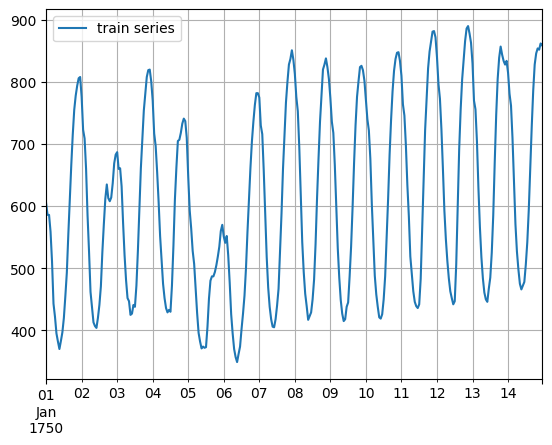

In [9]:
to_pandas(next(iter(dataset.train)))[: 14 * 24].plot()
plt.grid(which="both")
plt.legend(["train series"], loc="upper left")
plt.show()

## Tuning parameters of DeepAR estimator

In [10]:
import optuna
import torch
from gluonts.dataset.split import split
from gluonts.evaluation import Evaluator
from gluonts.torch.model.deepar import DeepAREstimator

We will now tune the DeepAR estimator on our training data using Optuna. We choose two hyperparameters `num_layers` and `hidden_size` to optimize.

First, we define a `dataentry_to_dataframe` method to transform a `DataEntry` into a `pandas.DataFrame`.
Second, we define an `DeepARTuningObjective` class used in tuning process of Optuna.
The class can be configured with the dataset, prediction length and data frequency, and the metric to be used for evaluating the model.
In the `__init__` method, we initialize the objective and split the dataset using `split` method existed in our GluonTS project.
- `validation_input`: the input part used in validation
- `validation_label`: the label part used in validation
In the `get_params` method, we define what hyperparameters to be tuned within given range.
In the `__call__` method, we define the way the `DeepAREstimator` is used in training and validation.

In [11]:
def dataentry_to_dataframe(entry):
    """
    Convert a GluonTS DataEntry to a pandas DataFrame.
    """
    df = pd.DataFrame(
        entry["target"],
        columns=[entry.get("item_id")],
        index=pd.period_range(
            start=entry["start"], periods=len(entry["target"]), freq=entry["start"].freq
        ),
    )

    return df


class DeepARTuningObjective:
    def __init__(
        self,
        dataset,
        prediction_length,
        freq,
        metric_type="mean_wQuantileLoss",
    ):
        """
        Defines our objective function for tuning the DeepAR model.
        """
        self.dataset = dataset
        self.prediction_length = prediction_length
        self.freq = freq
        self.metric_type = metric_type

        self.train, test_template = split(dataset, offset=-self.prediction_length)
        validation = test_template.generate_instances(
            prediction_length=prediction_length
        )
        self.validation_input = [entry[0] for entry in validation]
        self.validation_label = [
            dataentry_to_dataframe(entry[1]) for entry in validation
        ]

    def get_params(self, trial) -> dict:
        """
        Get the parameters for the DeepAR model based on the trial.
        """
        return {
            "num_layers": trial.suggest_int("num_layers", 1, 5),
            "hidden_size": trial.suggest_int("hidden_size", 10, 50),
        }

    def __call__(self, trial):
        params = self.get_params(trial)
        estimator = DeepAREstimator(
            num_layers=params["num_layers"],
            hidden_size=params["hidden_size"],
            prediction_length=self.prediction_length,
            freq=self.freq,
            trainer_kwargs={
                "enable_progress_bar": False,
                "enable_model_summary": False,
                "max_epochs": 10,
            },
        )

        predictor = estimator.train(self.train, cache_data=True)
        forecast_it = predictor.predict(self.validation_input)

        forecasts = list(forecast_it)

        evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
        agg_metrics, item_metrics = evaluator(
            self.validation_label, forecasts, num_series=len(self.dataset)
        )
        return agg_metrics[self.metric_type]

We can now invoke the Optuna tuning process.

In [12]:
import time

start_time = time.time()
study = optuna.create_study(direction="minimize")
study.optimize(
    DeepARTuningObjective(
        dataset.train, dataset.metadata.prediction_length, dataset.metadata.freq
    ),
    n_trials=5,
)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
print(time.time() - start_time)

[I 2025-06-30 01:37:24,771] A new study created in memory with name: no-name-80caaf97-07cb-4b06-9a75-c0c6d5f1a760
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
c:\Users\Mike\anaconda3\envs\gift\Lib\site-packages\lightning\pytorch\trainer\configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: Epoch 0, global step 50: 'train_loss' reached 5.70749 (best 5.70749), saving model to 'c:\\Users\\Mike\\vscode\\gift-eval\\notebooks\\lightning_logs\\version_0\\checkpoints\\epoch=0-step=50.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached 5.70749 (best 5.70749), sav

Number of finished trials: 5
Best trial:
  Value: 0.06936755619876907
  Params: 
    num_layers: 2
    hidden_size: 21
148.60448694229126


## Re-training the model

After getting the best hyperparameters by optuna, you can set them into the DeepAR estimator to re-train the model on the whole training subset we consider here.

In [ ]:
estimator = DeepAREstimator(
    num_layers=trial.params["num_layers"],
    hidden_size=trial.params["hidden_size"],
    prediction_length=dataset.metadata.prediction_length,
    context_length=100,
    freq=dataset.metadata.freq,
    trainer_kwargs={
        "enable_progress_bar": False,
        "enable_model_summary": False,
        "max_epochs": 10,
    },
)

After specifying our estimator with all the necessary hyperparameters we can train it using our training dataset `train_subset` by invoking the `train` method of the estimator. The training algorithm returns a fitted model (or a `Predictor` in GluonTS parlance) that can be used to obtain forecasts.

In [ ]:
predictor = estimator.train(dataset.train, cache_data=True)

## Visualize and evaluate forecasts

With a predictor in hand, we can now predict the last window of the test dataset and evaluate our model's performance.

GluonTS comes with the `make_evaluation_predictions` function that automates the process of prediction and model evaluation. Roughly, this function performs the following steps:

- Removes the final window of length `prediction_length` of the test dataset that we want to predict
- The estimator uses the remaining data to predict (in the form of sample paths) the "future" window that was just removed
- The forecasts are returned, together with ground truth values for the same time range (as python generator objects)

In [ ]:
from gluonts.evaluation import make_evaluation_predictions

forecast_it, ts_it = make_evaluation_predictions(
    dataset=dataset.test,
    predictor=predictor,
)

First, we can convert these generators to lists to ease the subsequent computations.

In [ ]:
forecasts = list(forecast_it)
tss = list(ts_it)

`Forecast` objects have a `plot` method that can summarize the forecast paths as the mean, prediction intervals, etc. The prediction intervals are shaded in different colors as a "fan chart".

In [ ]:
plt.plot(tss[0][-150:].to_timestamp())
forecasts[0].plot(show_label=True)
plt.legend()

We can also evaluate the quality of our forecasts numerically. In GluonTS, the `Evaluator` class can compute aggregate performance metrics, as well as metrics per time series (which can be useful for analyzing performance across heterogeneous time series).

In [ ]:
from gluonts.evaluation import Evaluator

In [ ]:
evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
agg_metrics, item_metrics = evaluator(tss, forecasts)

Aggregate metrics aggregate both across time-steps and across time series.

In [ ]:
print(json.dumps(agg_metrics, indent=4))

Individual metrics are aggregated only across time-steps.

In [ ]:
item_metrics.head()

In [ ]:
item_metrics.plot(x="sMAPE", y="MASE", kind="scatter")
plt.grid(which="both")
plt.show()